In [1]:
import pandas as pd 
import numpy as np 
import nltk 
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn import tree

from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import collections, numpy

In [3]:
df= pd.read_csv('Twitter_Emotion_Dataset.csv') 

In [4]:
print("Missing dataset value in all : ",df.isnull().values.any())

Missing dataset value in all :  False


In [5]:
df.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [6]:
df.shape

(4401, 2)

In [7]:
print('Jumlah kolom pada dataset:  ', len(df.columns))
print('Jumlah baris pada dataset:  ', len(df))

Jumlah kolom pada dataset:   2
Jumlah baris pada dataset:   4401


C:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


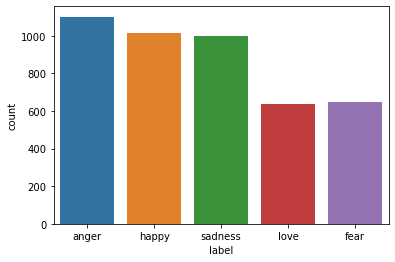

In [8]:
sns.countplot(df['label'],label="Count") #Grafik pada kolom label
plt.show() 

In [9]:
collections.Counter(df['label'])

Counter({'anger': 1101,
         'happy': 1017,
         'sadness': 997,
         'love': 637,
         'fear': 649})

In [10]:
def case_folding(tweet):  
    tweet = tweet.lower()
    
    return tweet
df['tweet']= df['tweet'].apply(case_folding)  

In [11]:
df.head()

,label,tweet
0,anger,"soal jln jatibaru,polisi tdk bs gertak gubernu..."
1,anger,"sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,kepingin gudeg mbarek bu hj. amad foto dari go...
3,anger,"jln jatibaru,bagian dari wilayah tn abang.peng..."
4,happy,"sharing pengalaman aja, kemarin jam 18.00 bata..."


In [12]:
df['tweet'][2489]

'ga pernah dipaksa sih buat berkerudung. tapi dari sd udah keinginan sendiri juga. tapi sayang kata mama, waktu itu kelas 4, bentar lagi lulus drpd beli baju lagi.'

In [13]:
def clean_tweet(tweet):
    
    # remove special characters 
    tweet = re.sub('[^ a-zA-Z0-9]', ' ', tweet)
    
    # remove number
    tweet = re.sub(r'[0-9]+', '', tweet)
    
    #remove url 
    tweet = re.sub("url", "", tweet)
    
    #remove username 
    tweet = re.sub('username', '', tweet)
    
    #remove sensitiveno
    tweet = re.sub('sensitiveno', '', tweet)
    
    #remove URL 
    tweet = re.sub("https", "", tweet)
    
    # remove askfm
    tweet = re.sub('askfm', '', tweet)
    
    #remove double spasi
    tweet= " ".join(tweet.split())    
    return tweet
df['tweet']= df['tweet'].apply(clean_tweet)

In [14]:
df['tweet'][2489]

'ga pernah dipaksa sih buat berkerudung tapi dari sd udah keinginan sendiri juga tapi sayang kata mama waktu itu kelas bentar lagi lulus drpd beli baju lagi'

In [15]:
key_norm = pd.read_csv('kamus_normalisasi.csv')

def normalisasi(tweet):
    tweet = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] 
                      if (key_norm["singkat"] == word).any() else word for word in tweet.split()])
    return tweet
df['tweet']= df['tweet'].apply(normalisasi)

In [16]:
df['tweet'][2489]

'tidak pernah dipaksa sih buat berkerudung tapi dari sd sudah keinginan sendiri juga tapi sayang kata mama waktu itu kelas bentar lagi lulus daripada beli baju lagi'

In [17]:
text = df['tweet'].values
y = df['label'].values

In [18]:
text.shape

(4401,)

# Bag of Word

In [19]:
# bag of words
bow = CountVectorizer()
X_bow = bow.fit_transform(text)

In [20]:
X_train_bow,X_test_bow,y_train_bow,y_test_bow= train_test_split(X_bow, y,test_size=0.1,random_state=0,stratify=y)

In [21]:
counter = Counter(y_train_bow)
print('Jumlah',counter)

Jumlah Counter({'anger': 991, 'happy': 915, 'sadness': 897, 'fear': 584, 'love': 573})


In [22]:
counter = Counter(y_test_bow)
print('Jumlah',counter)

Jumlah Counter({'anger': 110, 'happy': 102, 'sadness': 100, 'fear': 65, 'love': 64})


In [23]:
print(X_train_bow.shape)
print(X_test_bow.shape)
print(y_train_bow.shape)
print(y_test_bow.shape)

(3960, 17063)
(441, 17063)
(3960,)
(441,)


# Decision Tree

In [24]:
DT1 = DecisionTreeClassifier(random_state=0)
DT1.fit(X_train_bow, y_train_bow) 

DecisionTreeClassifier(random_state=0)

In [25]:
# kalau 67 hasil train 51.41 dan test 54.42 


In [26]:
# Pengujian data train dengan 10-Fold CV
scores = cross_val_score(DT1,X_train_bow, y_train_bow, cv=10)
print("Decision Tree(BOW) KFold Train Accuracy",scores.mean())

Decision Tree(BOW) KFold Train Accuracy 0.5098484848484849


In [27]:
# Evaluasi training tiap skenario dengan 10-Fold CV
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
score1 = cross_validate(DT1, X_train_bow, y_train_bow, cv=10, scoring=scoring)
print("training")
print(" %0.4f"% score1['test_accuracy'].mean())
print(" %0.4f"% score1['test_precision_macro'].mean())
print(" %0.4f"% score1['test_recall_macro'].mean())
print(" %0.4f"% score1['test_f1_macro'].mean())

training
 0.5098
 0.5376
 0.5296
 0.5318


In [28]:
# Pengujian data test dengan confusion matrix 
pred1 = DT1.predict(X_test_bow)
print("Classification: \n",confusion_matrix(y_test_bow, pred1))
accuracy = accuracy_score(y_test_bow, pred1)
print(' {:.2f}%'.format(accuracy * 100))
precision = precision_score(y_test_bow, pred1, average='macro')
print(' {:.2f}%'.format(precision * 100))
recall = recall_score(y_test_bow, pred1, average='macro')
print(' {:.2f}%'.format(recall * 100))
f1 = f1_score(y_test_bow, pred1, average='macro')
print(' {:.2f}%'.format(f1 * 100))

Classification: 
 [[63  6 12  4 25]
 [13 40  5  1  6]
 [20  6 41  9 26]
 [ 0  2 10 43  9]
 [33  8 24  8 27]]
 48.53%
 50.62%
 50.64%
 50.53%


In [29]:
print("MODEL 9               : Decision Tree")
print("Feature Extraction    : Bag of Word")
print("Tuning Hyperparameter : Tidak Ada")
print("SMOTE                 : Tidak ")
print("Classification Report: \n",classification_report(y_test_bow, pred1))

MODEL 9               : Decision Tree
Feature Extraction    : Bag of Word
Tuning Hyperparameter : Tidak Ada
SMOTE                 : Tidak 
Classification Report: 
               precision    recall  f1-score   support

       anger       0.49      0.57      0.53       110
        fear       0.65      0.62      0.63        65
       happy       0.45      0.40      0.42       102
        love       0.66      0.67      0.67        64
     sadness       0.29      0.27      0.28       100

    accuracy                           0.49       441
   macro avg       0.51      0.51      0.51       441
weighted avg       0.48      0.49      0.48       441



(5.5, -0.5)

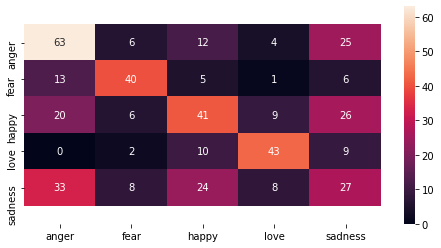

In [30]:
cm = confusion_matrix(y_test_bow, pred1)  
index = ['anger','fear','happy','love','sadness']  
columns = ['anger','fear','happy','love','sadness']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(8,4))  
ax = sns.heatmap(cm_df, annot=True, fmt="g")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Bigram

In [31]:
bigram = CountVectorizer(ngram_range=(2,2),analyzer='word') #bigram
X_bigram = bigram.fit_transform(text)

In [32]:
X_bigram.shape

(4401, 83519)

In [33]:
X_train_bigram,X_test_bigram,y_train_bigram,y_test_bigram= train_test_split(X_bigram, y,test_size=0.1,random_state=0,stratify=y)

In [34]:
print(X_train_bigram.shape)
print(X_test_bigram.shape)
print(y_train_bigram.shape)
print(y_test_bigram.shape)

(3960, 83519)
(441, 83519)
(3960,)
(441,)


In [35]:
counter = Counter(y_train_bigram)
print('Jumlah',counter)

Jumlah Counter({'anger': 991, 'happy': 915, 'sadness': 897, 'fear': 584, 'love': 573})


# Decision Tree

In [36]:
DT2=DecisionTreeClassifier(random_state=0)
DT2.fit(X_train_bigram, y_train_bigram) 

DecisionTreeClassifier(random_state=0)

In [37]:
# Evaluasi training tiap skenario dengan 10-Fold CV
scores3 = cross_val_score(DT2,X_train_bigram, y_train_bigram, cv=10)
print("Decision Tree(Bigram) KFold Train Accuracy",scores3.mean())

Decision Tree(Bigram) KFold Train Accuracy 0.43611111111111106


In [38]:
# Evaluasi training tiap skenario dengan 10-Fold CV
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
score2 = cross_validate(DT2, X_train_bigram, y_train_bigram, cv=10, scoring=scoring)
print("training")
print(" %0.4f"% score2['test_accuracy'].mean())
print(" %0.4f"% score2['test_precision_macro'].mean())
print(" %0.4f"% score2['test_recall_macro'].mean())
print(" %0.4f"% score2['test_f1_macro'].mean())

training
 0.4361
 0.4861
 0.4417
 0.4477


In [39]:
pred2 = DT2.predict(X_test_bigram) # prediksi oleh model
print(" %0.4f" % accuracy_score(y_test_bigram, pred2))
print(" %0.4f" % precision_score(y_test_bigram, pred2, average='macro'))
print(" %0.4f" % recall_score(y_test_bigram, pred2, average='macro'))
print(" %0.4f" % f1_score(y_test_bigram, pred2, average='macro'))
print(confusion_matrix(y_test_bigram, pred2))

 0.3946
 0.4217
 0.3888
 0.3851
[[42  5 47  5 11]
 [17 15 21  3  9]
 [ 8  7 66  8 13]
 [ 7  1 19 31  6]
 [24  7 42  7 20]]


In [40]:
print("MODEL 10              : Decision Tree")
print("Feature Extraction    : Bigram")
print("Tuning Hyperparameter : Tidak Ada")
print("SMOTE                 : Tidak ")
print("Classification Report: \n",classification_report(y_test_bigram, pred2))

MODEL 10              : Decision Tree
Feature Extraction    : Bigram
Tuning Hyperparameter : Tidak Ada
SMOTE                 : Tidak 
Classification Report: 
               precision    recall  f1-score   support

       anger       0.43      0.38      0.40       110
        fear       0.43      0.23      0.30        65
       happy       0.34      0.65      0.44       102
        love       0.57      0.48      0.53        64
     sadness       0.34      0.20      0.25       100

    accuracy                           0.39       441
   macro avg       0.42      0.39      0.39       441
weighted avg       0.41      0.39      0.38       441



(5.5, -0.5)

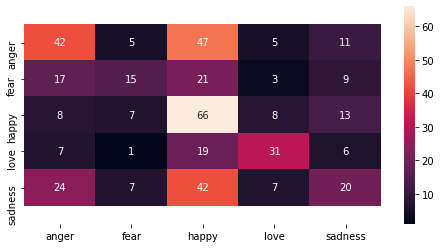

In [41]:
cm = confusion_matrix(y_test_bigram, pred2)  
index = ['anger','fear','happy','love','sadness']  
columns = ['anger','fear','happy','love','sadness']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(8,4))  
ax = sns.heatmap(cm_df, annot=True, fmt="g")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Pickle model 

In [ ]:
import joblib

In [ ]:
joblib.dump(DT1,'model9.pkl')

In [ ]:
joblib.dump(DT2,'model10.pkl')

In [45]:
test_msgs = ["Cintailah kekasihmu seperti dia mencintai mu dulu, seperti dia mencintai dengan tulus. Seseorang akan setia pada pasangannya karena cinta suami yang begitu besar pada ibu dan kalian berdua."]
test_msg_counts = bow.transform(test_msgs)

classifications = DT1.predict_proba(test_msg_counts)
emotion = DT1.predict(test_msg_counts)

print("emosi",emotion)
classifications


emosi ['love']


array([[0., 0., 0., 1., 0.]])

In [46]:
test_msgs = ["Cintailah kekasihmu seperti dia mencintai mu dulu, seperti dia mencintai dengan tulus. Seseorang akan setia pada pasangannya karena cinta suami yang begitu besar pada ibu dan kalian berdua."]
test_msg_counts = bigram.transform(test_msgs)

classifications = DT2.predict_proba(test_msg_counts)
emotion = DT2.predict(test_msg_counts)

print("emosi",emotion)
classifications


emosi ['love']


array([[0., 0., 0., 1., 0.]])